In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

# Add the 'surv_mcmc' directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from db_utils.eda_dataset_model import MusicService
from data_processing.DataFitting import SurvivalModelTester
import warnings

warnings.filterwarnings("ignore",
                        message="Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples.*")
warnings.filterwarnings("ignore",
                        message="The effect of Potentials on other parameters is ignored during prior predictive sampling.*")
warnings.filterwarnings("ignore",
                        message=" The effect of Potentials on other parameters is ignored during prior predictive sampling.*")
warnings.filterwarnings("ignore",
                        message="rcParams['plot.max_subplots']*")

plt.tight_layout()
# Suppress specific UserWarnings related to tight_layout
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)

c:\Users\runet\miniconda3\envs\pymc_new\lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\runet\miniconda3\envs\pymc_new\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\runet\miniconda3\envs\pymc_new\lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


<Figure size 640x480 with 0 Axes>

In [2]:
music_data = MusicService().get_music_data()

File snowflake_eda_tracks.csv loaded successfully
File snowflake_eda_tracks_playlists_302.csv loaded successfully
File snowflake_eda_tracks_discovery_302.csv loaded successfully


In [3]:
service = MusicService()
df = service.get_merged_data2(music_data)

In [6]:
df

,age,isrc,direct,high,low,mid,recommendation,num_playlists,streams,proportion_direct,...,total_discovery_streams,avg_inverse_length,avg_inverse_age,first_month_incomplete,censored,proportion_discovery,track_low,track_middle,track_popular,track_star
0,1,USUYG1366780,42401,18085,1186,4543,9646,2.0,75863.0,0.558915,...,27667.0,0.008268,0.009829,1.0,0,0.364697,True,False,False,False
1,1,USUYG1374061,89576,16298,1370,4512,66204,3.0,177963.0,0.503341,...,63610.0,0.008711,0.005304,0.0,0,0.357434,True,False,False,False
2,1,USUYG1374631,59144,177560,172,1770,4998,4.0,243648.0,0.242744,...,128728.0,0.009692,0.008807,1.0,0,0.528336,False,True,False,False
3,1,USUYG1374662,383549,14306,637,208,34821,3.0,433524.0,0.884724,...,90661.0,0.007017,0.008232,0.0,0,0.209126,False,False,True,False
4,1,USUYG1374820,159814,79560,2036,10936,7661,3.0,260010.0,0.614646,...,81692.0,0.007695,0.009775,1.0,0,0.314188,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10992,31,USUYG1414617,44422,27,355,283,2383,1.0,47471.0,0.935771,...,6725.0,0.008057,0.012236,0.0,1,0.141665,True,False,False,False
10993,31,USUYG1415980,52637,55,1189,810,3463,1.0,58155.0,0.905116,...,4564.0,0.008056,0.009295,0.0,1,0.078480,False,True,False,False
10994,31,USUYG1415981,88540,11,1375,1709,9699,1.0,101335.0,0.873736,...,11100.0,0.010989,0.008611,0.0,1,0.109538,False,True,False,False
10995,31,USUYG1415984,351103,6202,8310,5779,41984,4.0,413382.0,0.849343,...,18645.0,0.008228,0.011357,0.0,1,0.045104,False,False,True,False


In [4]:
influence_period_df = df[df['age'] <= 3]  # Influence period: ages 14 to 16
avg_discovery_influence = influence_period_df.groupby('isrc')['proportion_discovery'].mean()
growth_period_df = df[df['age'] > 3]
# Map `avg_discovery_influence` back to the longitudinal data for the growth period
# Create a new column in the growth_period_df that matches each individual with their average influence
growth_period_df = growth_period_df.copy()
growth_period_df['avg_discovery_influence'] = growth_period_df['isrc'].map(avg_discovery_influence)
id_indx, unique_ids = pd.factorize(growth_period_df["isrc"])
coords = {"ids": unique_ids, "obs": range(len(growth_period_df))}
censored = growth_period_df['censored'].values.astype(bool)
log_total_streams = np.log(growth_period_df['streams'].values + 1)
observed_data = log_total_streams[~censored]
censored_data = log_total_streams[censored]

# Discovery influence OLS

Columns in correlation_df: Index(['isrc', 'avg_discovery_influence', 'slope', 'popularity'], dtype='object')
Processing group: middle, Data count: 90
Popularity group: middle
  Correlation between avg_discovery_influence and slope of streams: -0.12
  P-value: 0.2571

Processing group: popular, Data count: 75
Popularity group: popular
  Correlation between avg_discovery_influence and slope of streams: -0.20
  P-value: 0.0903

Processing group: low, Data count: 120
Popularity group: low
  Correlation between avg_discovery_influence and slope of streams: -0.30
  P-value: 0.0008

Processing group: star, Data count: 17
Popularity group: star
  Correlation between avg_discovery_influence and slope of streams: 0.66
  P-value: 0.0041



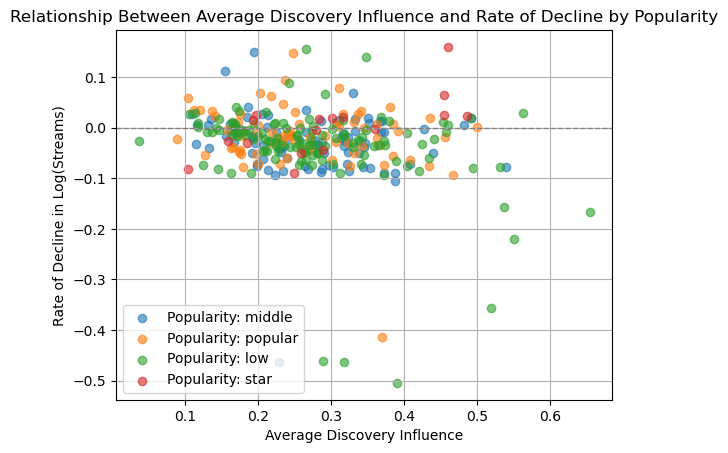

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming `growth_period_df` is already available and contains 'isrc', 'age', 'streams', and 'avg_discovery_influence'

# Step 1: Calculate the rate of decline for each `isrc` (song)
slopes = []

for isrc in growth_period_df['isrc'].unique():
    # Subset data for each individual song
    song_data = growth_period_df[growth_period_df['isrc'] == isrc]
    X = sm.add_constant(song_data['age'].values)  # Add constant for intercept in linear regression
    y = np.log(song_data['streams'].values + 1)  # Log-transform the streams to match the model

    # Fit a linear regression model to obtain the slope (rate of decline)
    model = sm.OLS(y, X).fit()
    slope = model.params[1]  # Get the slope (change in log(streams) over time)
    slopes.append((isrc, slope))

# Create a DataFrame with slopes
slopes_df = pd.DataFrame(slopes, columns=['isrc', 'slope'])

# Step 2: Merge avg_discovery_influence and slopes to create a correlation dataset
correlation_df = pd.merge(
    avg_discovery_influence.reset_index(),  # Reset index to merge easily
    slopes_df,
    on='isrc'
)
# Assuming `growth_period_df` and `slopes_df` are available from the previous steps
# Assuming popularity columns are in growth_period_df

# Step 1: Create a unified popularity label for each track based on the one-hot columns
def get_popularity_category(row):
    if row['track_star']:
        return 'star'
    elif row['track_popular']:
        return 'popular'
    elif row['track_middle']:
        return 'middle'
    elif row['track_low']:
        return 'low'
    else:
        return 'unknown'

# Apply the function to get a single column representing the popularity category
growth_period_df['popularity'] = growth_period_df.apply(get_popularity_category, axis=1)

# Step 2: Merge avg_discovery_influence and slopes_df with popularity information
# Ensure avg_discovery_influence is present and properly named
avg_discovery_influence = avg_discovery_influence.reset_index().rename(columns={'proportion_discovery': 'avg_discovery_influence'})

# Merge avg_discovery_influence and slopes_df based on 'isrc'
correlation_df = pd.merge(avg_discovery_influence, slopes_df, on='isrc')

# Merge popularity category information with correlation data
correlation_df = pd.merge(
    correlation_df,
    growth_period_df[['isrc', 'popularity']].drop_duplicates(),
    on='isrc'
)

# Verify columns in correlation_df
print("Columns in correlation_df:", correlation_df.columns)

# Step 3: Calculate the correlation for each popularity category separately
popularity_groups = correlation_df['popularity'].unique()

# Loop through each popularity group and calculate correlation
for group in popularity_groups:
    group_data = correlation_df[correlation_df['popularity'] == group]

    # Print group info for debugging
    print(f"Processing group: {group}, Data count: {len(group_data)}")

    if len(group_data) > 1:  # Ensure there are enough data points for correlation
        try:
            corr_value, p_value = pearsonr(group_data['avg_discovery_influence'], group_data['slope'])
            print(f"Popularity group: {group}")
            print(f"  Correlation between avg_discovery_influence and slope of streams: {corr_value:.2f}")
            print(f"  P-value: {p_value:.4f}\n")
        except KeyError as e:
            print(f"KeyError occurred: {e} - Columns available: {group_data.columns}")
    else:
        print(f"Not enough data points for popularity group: {group}\n")

# Step 4: Visualize the relationships

for group in popularity_groups:
    group_data = correlation_df[correlation_df['popularity'] == group]
    if len(group_data) > 1:
        plt.scatter(group_data['avg_discovery_influence'], group_data['slope'], alpha=0.6, label=f'Popularity: {group}')

plt.xlabel('Average Discovery Influence')
plt.ylabel('Rate of Decline in Log(Streams)')
plt.title('Relationship Between Average Discovery Influence and Rate of Decline by Popularity')
plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.legend()
plt.grid(True)
plt.show()

# Discovery simple OLS

In [14]:
from sklearn.preprocessing import StandardScaler

scaler_age = StandardScaler()
growth_period_df['age_scaled'] = scaler_age.fit_transform(growth_period_df[['age']])

scaler_influence = StandardScaler()
growth_period_df['avg_discovery_influence_scaled'] = scaler_influence.fit_transform(
    growth_period_df[['avg_discovery_influence']]
)
X = growth_period_df[['age_scaled', 'avg_discovery_influence_scaled']]
X['interaction'] = X['age_scaled'] * X['avg_discovery_influence_scaled']
X = sm.add_constant(X)
y = log_total_streams
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     164.5
Date:                Wed, 13 Nov 2024   Prob (F-statistic):          4.30e-104
Time:                        17:31:22   Log-Likelihood:                -18257.
No. Observations:               10091   AIC:                         3.652e+04
Df Residuals:                   10087   BIC:                         3.655e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

C:\Users\runet\AppData\Local\Temp\ipykernel_4776\2207773551.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['interaction'] = X['age_scaled'] * X['avg_discovery_influence_scaled']


In [27]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

preds = [
    'age', 
    'avg_discovery_influence', 
    'proportion_high', 
    'proportion_low', 
    'proportion_mid', 
    'proportion_recommendation'
]
X = growth_period_df[preds]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,age,4.250280
1,avg_discovery_influence,5.526509
2,proportion_high,1.239297
3,proportion_low,1.280431
4,proportion_mid,1.466480
5,proportion_recommendation,3.340400


In [28]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Columns that need standardization
columns_to_scale = preds = [
    'age', 
    'avg_discovery_influence', 
    'proportion_high', 
    'proportion_low', 
    'proportion_mid', 
    'proportion_recommendation'
]

# Standardize each of the columns in columns_to_scale
scalers = {}
for column in columns_to_scale:
    scaler = StandardScaler()
    growth_period_df[f'{column}_scaled'] = scaler.fit_transform(growth_period_df[[column]])
    scalers[column] = scaler  # Store scaler if needed for later inverse transform

# Create feature matrix X with the scaled versions of the columns
scaled_columns = [f'{column}_scaled' for column in columns_to_scale]
X = growth_period_df[scaled_columns]

# Add the interaction between `age_scaled` and `avg_discovery_influence_scaled`
X['interaction'] = X['age_scaled'] * X['avg_discovery_influence_scaled']

# Add Boolean variables (converted to int)
boolean_columns = ['track_low', 'track_middle', 'track_popular', 'track_star']
for column in boolean_columns:
    X[column] = growth_period_df[column].astype(int)

# Add a constant term for the intercept
X = sm.add_constant(X)

# Define the response variable `y`
y = log_total_streams

# Fit the OLS model
ols_model = sm.OLS(y, X).fit()

# Print the summary of the model
print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     1035.
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        17:50:29   Log-Likelihood:                -14934.
No. Observations:               10091   AIC:                         2.989e+04
Df Residuals:                   10080   BIC:                         2.997e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

C:\Users\runet\AppData\Local\Temp\ipykernel_4776\1899154008.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['interaction'] = X['age_scaled'] * X['avg_discovery_influence_scaled']
C:\Users\runet\AppData\Local\Temp\ipykernel_4776\1899154008.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = growth_period_df[column].astype(int)
C:\Users\runet\AppData\Local\Temp\ipykernel_4776\1899154008.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u